# 計算機実習 問題12.16 拡散が支配する1次元化学反応系のモンテカルロ・シミュレーション

## シミュレーションの目的

単一の種類Aの粒子からなる系を考える、全ての粒子は拡散し、2個の粒子が衝突する"反応"が起こり、1個の粒子が消えるか2個の粒子が結合して、もはや反応には関わらない不活性な種類の粒子になる。
後者の場合の化学反応は

$$A + A \rightarrow 0\ \ \ (\text{不活性})$$
と表すことができる。A粒子の密度の空間的ゆらぎを無視すると、その時間変化は簡単な反応速度方程式

$$\frac{dA(t)}{dt} = -kA^{2}(t)$$
で与えることができる。ここで$A$はA粒子の時刻$t$の密度であり、$k$は反応速度定数である。簡単のために、全ての反応物質が$t=0$に加えられ、その後には反応物質は何も加えられないとする(閉じた系)。1階微分方程式(上式)の解は

$$A(t) = \frac{1}{kt + 1/A(0)}$$
であり、長時間の極限では
        
$$A(t) \sim t^{-1}$$
となる。

上に述べた1種類の粒子が消滅する過程における$A$の時間依存性は簡単であるが、空間ゆらぎが無視されている。ここでは、この過程の時間発展のシミュレーションを行い、仮定が正しいか調べることにする。

## 作成したプログラム

本シミュレーションで作成したプログラムを以下に示す。

In [1]:
#! /usr/bin/env python
# -*- coding:utf-8 -*-
#
# written by Shotaro Fujimoto, June 2014.

import numpy as np


def main_rw_d1(L, N, pmax):

    lattice = np.identity(L, dtype=int)
    T = [2 ** p for p in range(1, pmax + 1)]
    A = []
    random = np.random.rand
    np_sum = np.sum
    np_roll = np.roll

    for t in xrange(1, max(T) + 1):
        # 1 step ==============================================================
        for n in xrange(N):
            if np_sum(lattice[n]):
                if random() > 0.5:
                    lattice[n] = np_roll(lattice[n], 1)
                else:
                    lattice[n] = np_roll(lattice[n], -1)

        count = np_sum(lattice, axis=0)

        for l in xrange(L):
            if count[l] == 2:
                for n in xrange(N):
                    lattice[n][l] = 0
        # =====================================================================
        if t in T:
            A.append(L / (1. * np_sum(lattice)) - 1)

    return T, A


def plot_graph(x_data, y_data, x_labels, y_labels,
               xscale='linear', yscale='linear', aspect='auto'):
    """ Plot the graph about y_data for each x_data.
    """
    import matplotlib.pyplot as plt

    d = len(y_data)
    if not len(x_data) == len(y_data) == len(x_labels) == len(y_labels):
        raise ValueError("Arguments must have the same dimension.")
    if d == 0:
        raise ValueError("At least one data for plot.")
    if d > 9:
        raise ValueError("""So much data for plot in one figure.
                            Please divide two or more data sets.""")

    fig = plt.figure(figsize=(9, 8))
    subplot_positioning = [
        '11', '21', '22', '22', '32', '32', '33', '33', '33']
    axes = []
    for n in range(d):
        lmn = int(subplot_positioning[d - 1] + str(n + 1))
        axes.append(fig.add_subplot(lmn))

    for i, ax in enumerate(axes):
        ymin, ymax = min(y_data[i]), max(y_data[i])
        ax.set_aspect(aspect)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.set_xlabel(x_labels[i], fontsize=16)
        ax.set_ylabel(y_labels[i], fontsize=16)
        ax.set_ymargin(0.05)
        ax.plot(x_data[i], y_data[i], 'o-')

    fig.subplots_adjust(wspace=0.2, hspace=0.5)
    fig.tight_layout()
    plt.show()


def fitting(fit_func, parameter0, trial=10):
    import scipy.optimize as optimize

    a = np.zeros(trial)
    for i in range(trial):
        T, A = main_rw_d1(L, N, pmax)
        x, y = np.array(T), np.array(A)
        result = optimize.leastsq(fit_func, parameter0, args=(x, y))
        a[i] = result[0][0]

    print 'a =', np.average(a), 'sigma(a) =', np.std(a)

このプログラムは3つの関数からなっている。関数main\_rw\_d1は、1次元格子上を複数の粒子がランダムウォークし、同じ格子点上に2個の粒子が来たときその粒子を取り除くような挙動を実現する。関数plot\_graphは、問題12−12でも用いたグラフ描画のための関数である。関数fittingは、$1/A(t)-1$の$t$に関する両対数グラフを直線でフィッティングしたときのその傾きを求めるものである。何回か試行を繰り返し、その平均値と偏差を返すようにしてある。

関数main\_rw\_d1の動きについての解説を加えると、まずlatticeは行方向が粒子を表し、列方向は座標を表している。単位行列によって$A(t=0)=1$を表現し、時間発展ごとに右向きか左向きに等確率でシフトする。その後、列方向に和を計算し、その値が2であるときはその列の要素をすべて0にしている(2以上の値となることはない)。この操作を繰り返し、時刻$t(=2^{p}(p = 1,2,3,\cdots, \mathrm{pmax}))$のときの$1/A(t)-1$の値をAに追加している。ここで$t$は対数プロットしたときのデータが等間隔になるように、指数関数的にとった。

## 実習課題

### a.

$N$個の粒子が、長さ$L$の1次元格子上を周期的境界条件の下でランダムウォークを行う場合を考え、全ての格子点が占有されている状態$A(t=0)=1$からシミュレーションを始めよ。量$1/A(t)-1$を時間$t$に対して両対数でプロットせよ。対数プロットのデータが等間隔になるように、時間の区間を指数関数的にとれ。長時間の極限では、得られた両対数プロットは直線的か、直線ならばその傾きを求めよ。平均場近似は1次元で正しいといえるか。$L=100$程度の小さい格子と、$t=10^{2}$程度の時間で大雑把な結果を得ることができる。10パーセント以内の精度で結果を得るためには、$L=10^{4}$程度の大きさの格子と$t=2^{13}$程度の時間が必要である。

上記のプログラムを用いて、$N$個の粒子が1次元周期境界条件のもとでランダムウォークを行い、反応によって不活性化する問題をシミュレーションした。このとき、条件として、格子の大きさ$L=1000$で、時刻$t=512(=2^{9})$までの計算を行った。$A(t)$を時刻$t$での粒子の密度として、量$1/A(t)-1$を時間$t$に対して両対数プロットし、これを図に示した。図から分かるように、この両対数プロットは直線的であり、$A(t)$と$t$の間にベキ乗則が成り立つことが分かる。実際にグラフにおける直線の傾き$a$を算出してみると、10回の試行の平均値として$a = 0.512988987355$が得られた。このときの分散$\sigma$は$\sigma = 0.0521364760422$であった。したがって、時刻$t$とその時刻での粒子の存在密度$A(t)$の間には、およそ以下のような関係が成り立つと分かる:

$$A(t) \sim t^{-\frac{1}{2}}$$
この結果は、空間ゆらぎを考慮せず解析的に求めた、長時間後の$A(t)$と$t$の関係と異なっている。したがって、はじめに述べたように平均場近似をすることは妥当でなく、粒子密度の空間的なゆらぎの効果は無視できないことが分かった。

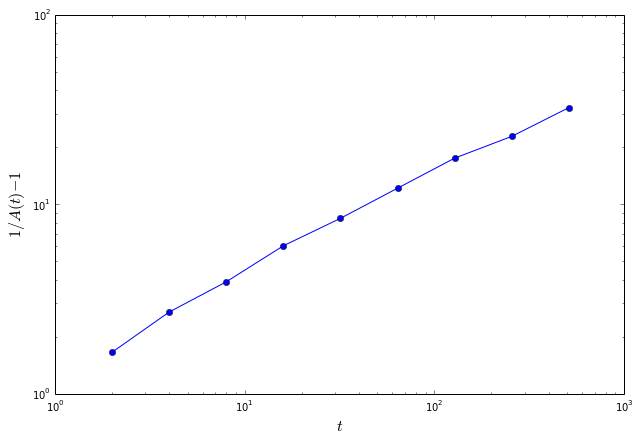

In [3]:
%matplotlib inline
L = 1000
N = L
pmax = 9

T, A = main_rw_d1(L, N, pmax)
plot_graph([T], [A], [r'$t$'], [r'$1/A(t)-1$'],
           xscale='log', yscale='log', aspect='equal')

def fit_func(parameter0, t, y):
    a = parameter0[0]
    b = parameter0[1]
    residual = y - b * (t ** a)
    return residual
parameter0 = [1, 0]  # a, b
# fitting(fit_func, parameter0, trial=10)

## まとめ

1次元の化学反応系の簡単な例について考え、粒子の存在密度$A(t)$と時刻$t$の間にベキ乗則が成り立ち、その指数の値が平均場近似より求められた値と異なることを示した。

## 参考文献

- ハーベイ・ゴールド,ジャン・トボチニク,石川正勝・宮島佐介訳『計算物理学入門』,ピアソン・エデュケーション, 2000.